In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
cm = sns.light_palette("green", as_cmap=True)

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [3]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
exchange

exchange_id exchange_name
0             0       Unknown
1             1         Fyber
2             2        Smaato
3             3         MoPub
4             4        Nexage
5             7       Rubicon
6             8        Google
7             9        Axonix
8            10      PubMatic
9            11        MobFox
10           14         Opera
11           18     PubNative
12           21      Appodeal
13           22         Tappx
14           24      AdColony
15           29     SmartyAds
16           30    Chartboost
17           33   NexageVideo
18           36        Vungle
19           37         Unity
20           38         Unity
21           39         Unity
22           41      AppLovin
23           44        InMobi
24           45          SoMo
25           46  MobilityWare
26           47     GothamAds
27           48      Vertical
28           49          Kiip
29           50        MailRu
30           52          Epom
31           53    TripleLift
32           54    IronSource
33           55      StartApp
34           56       Algorix
35           57     RhythmOne
36           58       Etermax
37           59       Samsung
38           60     ByteDance
39           99          Test

In [4]:
start_dt = '2021-03-29'
end_dt = '2021-04-28'
change_start_dt = '2021-04-01'
change_end_dt = '2021-04-01'

(1) Confirm Applovin Throttle Removal Gains (4/1)

(2) Are the gains coming from new inventory? Or the same inventory?

(3) New Users? 

In [5]:
by_size_type = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , attr.ad_size
    , attr.imp_type
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 41
group by 1,2,3,4,5
""").to_dataframe()
by_size_type = pd.merge(by_size_type, imp_type, left_on = 'imp_type', right_on = 'imp_type_id')
by_size_type['date'] = by_size_type['date'].astype('datetime64')
by_size_type

buyer       date  with_change   ad_size  imp_type  impressions  clicks  \
0     RON 2021-03-29            0   480x320         1          976       0   
1     RON 2021-04-15            1    728x90         1        13360     336   
2      DT 2021-03-29            0   320x480         1         9280     192   
3      DT 2021-04-25            1   300x250         1        76864     304   
4     RON 2021-04-19            1   320x480         1        54336    1152   
..    ...        ...          ...       ...       ...          ...     ...   
553   RON 2021-04-02            1  1024x768         2        17920    1824   
554    DT 2021-04-14            1  1024x768         2        82192   14720   
555    DT 2021-04-02            1  768x1024         2       398864   77456   
556    DT 2021-04-25            1  1024x768         2       176128   35200   
557    DT 2021-04-20            1  768x1024         2       600384  108240   

     installs   spend impression type  imp_type_id  
0           0     0.0          banner            1  
1           0     NaN          banner            1  
2          16     8.0          banner            1  
3          48    81.6          banner            1  
4          16     4.8          banner            1  
..        ...     ...             ...          ...  
553        64   492.8           video            2  
554      1024  1739.2           video            2  
555      2560  3566.4           video            2  
556      1232  1602.4           video            2  
557      4416  6736.8           video            2  

[558 rows x 11 columns]

In [6]:
by_size_type_dt = by_size_type[by_size_type.buyer == 'DT']

In [7]:
def calc_metrics(x):
    x.at[:,'ctr'] = x.loc[:,'clicks']/x.loc[:,'impressions']
    x.at[:,'ir'] = x.loc[:,'installs']/x.loc[:,'clicks']
    x.at[:,'ipm'] = 1000*x.loc[:,'installs']/x.loc[:,'impressions']
    x.at[:,'cpi'] = x.loc[:,'spend']/x.loc[:,'installs']

def format_display(df):
    format_mapping = {'impressions':'{:,.0f}'
                     ,'clicks':'{:,.0f}'
                     ,'installs':'{:,.0f}'
                     ,'spend':'${:,.0f}'
                     ,'cpi':'${:,.2f}'
                     ,'ctr':'{:.1f}%'
                     ,'ir':'{:.1f}%'
                     ,'ipm':'{:.2f}'
                     }
    df = df[['impressions','clicks','ctr','installs','ir','ipm','cpi','spend']]
    df[['ctr','ir']] = df[['ctr','ir']]*100
    df['cpi'] = df['cpi'].fillna(0)
    return df.style.format(format_mapping)

In [8]:
change_total = by_size_type_dt.groupby('with_change')['impressions','clicks','installs','spend'].sum()
calc_metrics(change_total)
format_display(change_total)

<ipython-input-8-8ecb4d10f329>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  change_total = by_size_type_dt.groupby('with_change')['impressions','clicks','installs','spend'].sum()


In [9]:
by_day_total = by_size_type_dt.groupby('date')['impressions','clicks','installs','spend'].sum()
calc_metrics(by_day_total)
format_display(by_day_total)

<ipython-input-9-eba4fdd0bc9b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_total = by_size_type_dt.groupby('date')['impressions','clicks','installs','spend'].sum()


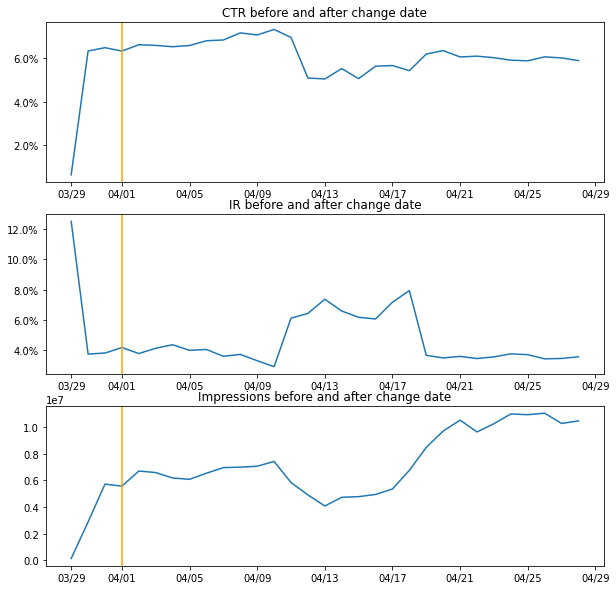

In [38]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
ax[0].plot(by_day_total[['ctr']]*100)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR before and after change date')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(by_day_total[['ir']]*100)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR before and after change date')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].plot(by_day_total[['impressions']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('Impressions before and after change date')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [11]:
change_type = by_size_type_dt.groupby(['impression type','with_change'])['impressions','clicks','installs','spend'].sum()
calc_metrics(change_type)
format_display(change_type)

<ipython-input-11-6b03aa574766>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  change_type = by_size_type_dt.groupby(['impression type','with_change'])['impressions','clicks','installs','spend'].sum()


In [12]:
by_day_type = by_size_type_dt.groupby(['impression type','date'])['impressions','clicks','installs','spend'].sum()
by_day_type.reset_index(inplace = True)
by_day_type['group_sum'] = by_day_type.groupby('impression type')['spend'].transform(sum)
by_day_type.sort_values(['group_sum','date'], ascending = [False, True], inplace = True)
by_day_type.set_index(['impression type','date'], inplace = True)
calc_metrics(by_day_type)
format_display(by_day_type)

<ipython-input-12-735db360b180>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_type = by_size_type_dt.groupby(['impression type','date'])['impressions','clicks','installs','spend'].sum()
/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-7-c126b29e200c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


impression type
banner            585692.96
video             230954.40
rewarded video    152085.12
Name: spend, dtype: float64


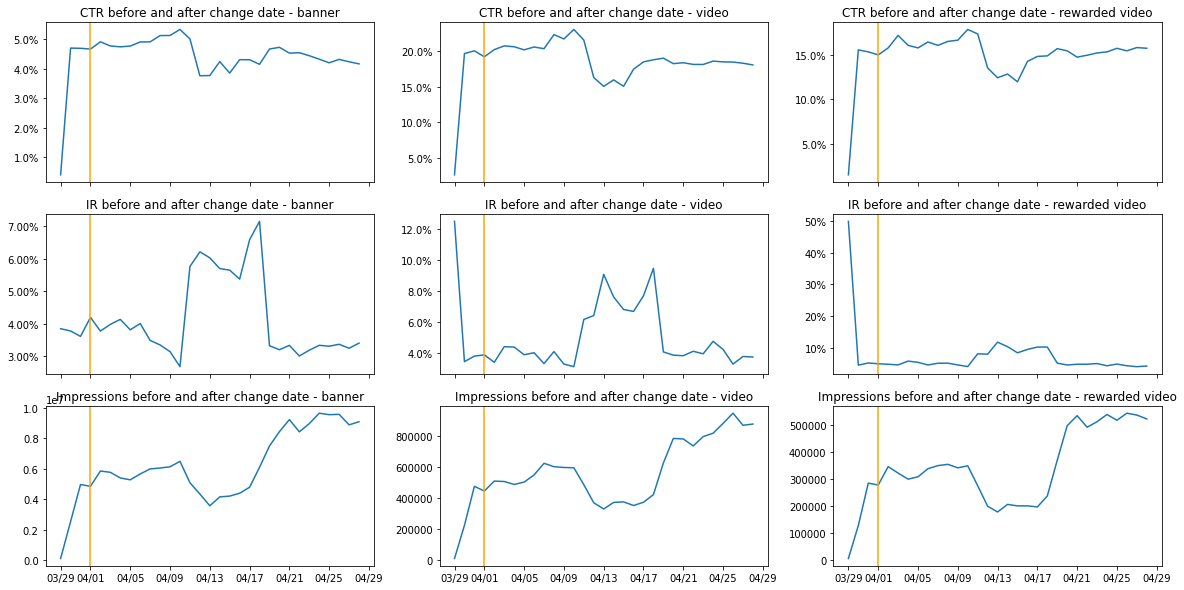

In [40]:
print(by_size_type_dt.groupby('impression type')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,3, figsize = (20,10),sharex = True)

for n in range(3):
    type_filter = by_day_type.index.get_level_values(0).unique()[n]
    filtered_by_type = by_day_type.loc[type_filter]
    ax[0,n].plot(pd.DataFrame(filtered_by_type['ctr']*100))
    ax[0,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].set_title(f'CTR before and after change date - {type_filter}')
    ax[0,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[1,n].plot(pd.DataFrame(filtered_by_type['ir']*100))
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].set_title(f'IR before and after change date - {type_filter}')
    ax[1,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].plot(pd.DataFrame(filtered_by_type['impressions']))
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].set_title(f'Impressions before and after change date - {type_filter}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [41]:
by_day_size_banners_dt = by_size_type_dt[by_size_type_dt['impression type'] == 'banner'].groupby(['ad_size','date'])['impressions','clicks','installs','spend'].sum()
by_day_size_banners_dt.reset_index(inplace = True)
by_day_size_banners_dt['group_sum'] = by_day_size_banners_dt.groupby('ad_size')['spend'].transform(sum)
by_day_size_banners_dt.sort_values(['group_sum','date'], ascending = [False, True], inplace = True)
by_day_size_banners_dt.set_index(['ad_size','date'], inplace = True)
calc_metrics(by_day_size_banners_dt)
format_display(by_day_size_banners_dt)

<ipython-input-41-c2615a97b643>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_size_banners_dt = by_size_type_dt[by_size_type_dt['impression type'] == 'banner'].groupby(['ad_size','date'])['impressions','clicks','installs','spend'].sum()
/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-7-c126b29e200c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

<ipython-input-42-49bea9c0049c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))


ad_size
320x50     311502.56
320x480    183252.80
480x320     88620.80
300x250      1260.80
728x90       1056.00
Name: spend, dtype: float64


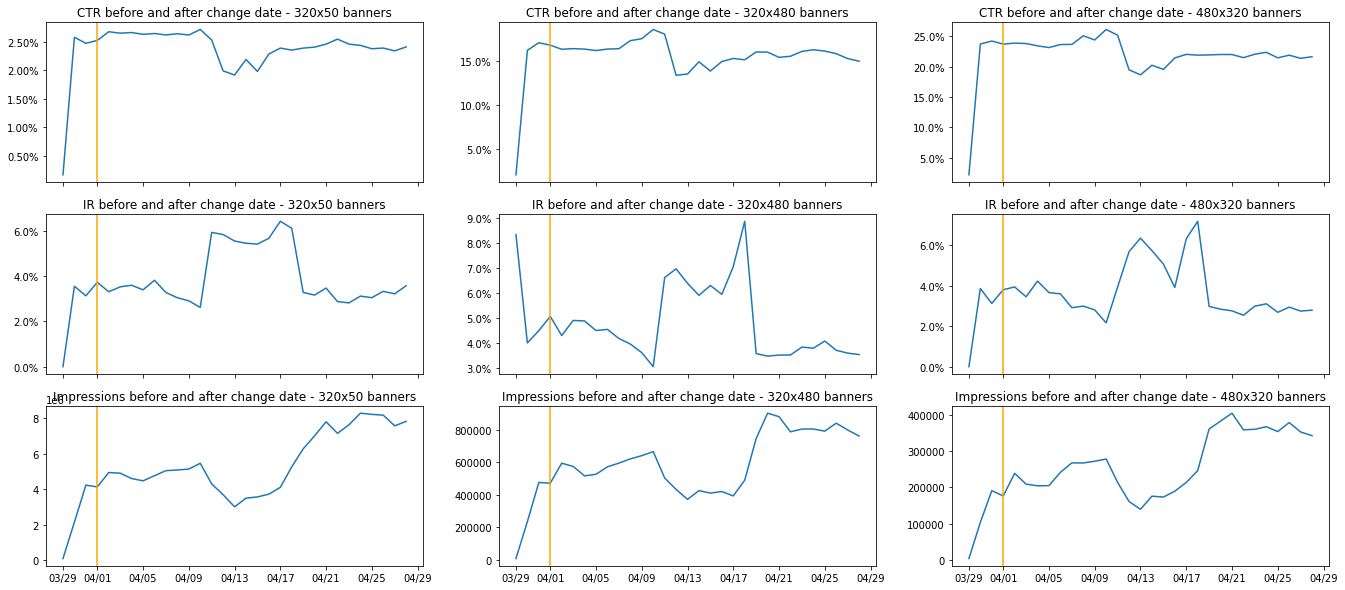

In [42]:
print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,3, figsize = (23,10), sharex = True)
for n in range(3):
    size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[n]
    filtered_by_size = by_day_size_banners_dt.loc[size_filter]
    ax[0,n].plot(pd.DataFrame(filtered_by_size['ctr']*100))
    ax[0,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].set_title(f'CTR before and after change date - {size_filter} banners')
    ax[1,n].plot(pd.DataFrame(filtered_by_size['ir']*100))
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].set_title(f'IR before and after change date - {size_filter} banners')
    ax[2,n].plot(pd.DataFrame(filtered_by_size['impressions']))
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].set_title(f'Impressions before and after change date - {size_filter} banners')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

<ipython-input-43-f17c0dd426fd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))


ad_size
320x50     311502.56
320x480    183252.80
480x320     88620.80
300x250      1260.80
728x90       1056.00
Name: spend, dtype: float64


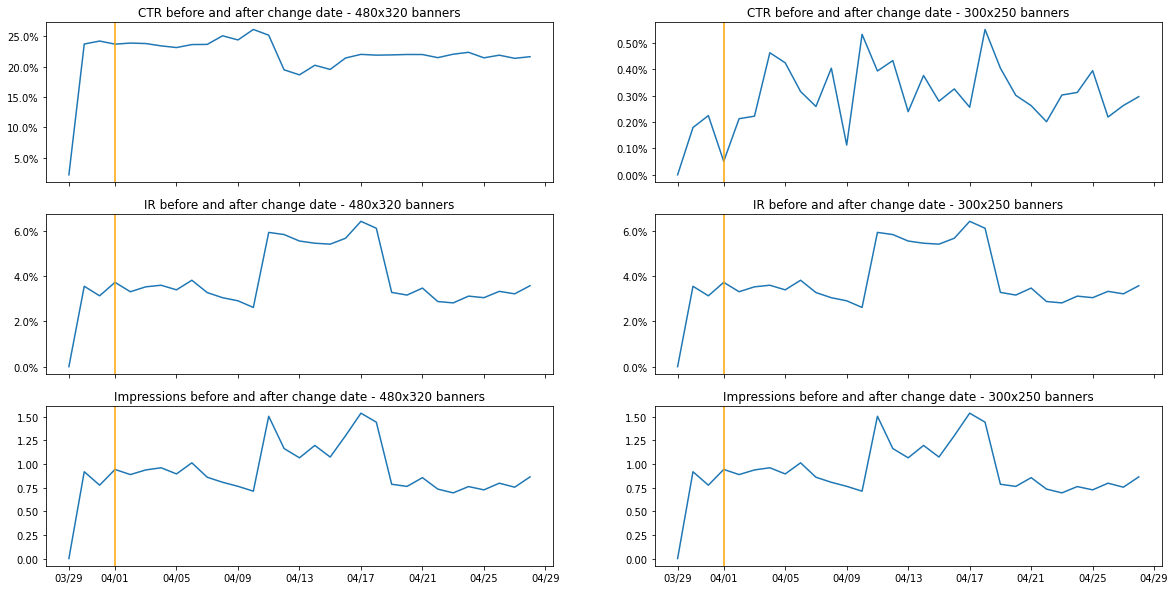

In [43]:
print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,2, figsize = (20,10), sharex = True)
size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[2]
filtered_by_size = by_day_size_banners_dt.loc[size_filter]
ax[0,0].plot(pd.DataFrame(filtered_by_size['ctr']*100))
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].set_title(f'CTR before and after change date - {size_filter} banners')
ax[1,0].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ir']*100)
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].set_title(f'IR before and after change date - {size_filter} banners')
ax[2,0].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ipm'])
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].set_title(f'Impressions before and after change date - {size_filter} banners')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[3]
filtered_by_size = by_day_size_banners_dt.loc[size_filter]
ax[0,1].plot(pd.DataFrame(filtered_by_size['ctr']*100))
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].set_title(f'CTR before and after change date - {size_filter} banners')
ax[1,1].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ir']*100)
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].set_title(f'IR before and after change date - {size_filter} banners')
ax[2,1].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ipm'])
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].set_title(f'Impressions before and after change date - {size_filter} banners')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [17]:
by_app_type = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , attr.ad_size
    , attr.imp_type
    , attr.hosting_app_id
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 41
group by 1,2,3,4,5,6
""").to_dataframe()
by_app_type = pd.merge(by_app_type, imp_type, left_on = 'imp_type', right_on = 'imp_type_id')
by_app_type['date'] = by_app_type['date'].astype('datetime64')
by_app_type

buyer       date  with_change   ad_size  imp_type  hosting_app_id  \
0         DT 2021-03-29            0  768x1024        16         1176334   
1         DT 2021-03-29            0  1024x768        16         1096538   
2         DT 2021-03-29            0  768x1024        16         1274106   
3         DT 2021-03-29            0  768x1024        16         1240316   
4        RON 2021-03-29            0  768x1024        16         1103621   
...      ...        ...          ...       ...       ...             ...   
538294    DT 2021-04-28            1  768x1024         2         1023660   
538295    DT 2021-04-28            1  1024x768         2         1140741   
538296    DT 2021-04-28            1  1024x768         2          871054   
538297    DT 2021-04-28            1  1024x768         2         1202802   
538298   RON 2021-04-28            1  768x1024         2         1117098   

        impressions  clicks  installs  spend impression type  imp_type_id  
0                32       0         0    0.0  rewarded video           16  
1                32       0         0    0.0  rewarded video           16  
2                16       0         0    0.0  rewarded video           16  
3                16       0         0    0.0  rewarded video           16  
4                16       0         0    0.0  rewarded video           16  
...             ...     ...       ...    ...             ...          ...  
538294           16      16         0    NaN           video            2  
538295           16       0         0    NaN           video            2  
538296           16       0         0    NaN           video            2  
538297          224      32         0    NaN           video            2  
538298           32       0         0    NaN           video            2  

[538299 rows x 12 columns]

In [44]:
by_app_type_dt = by_app_type[by_app_type.buyer == 'DT']

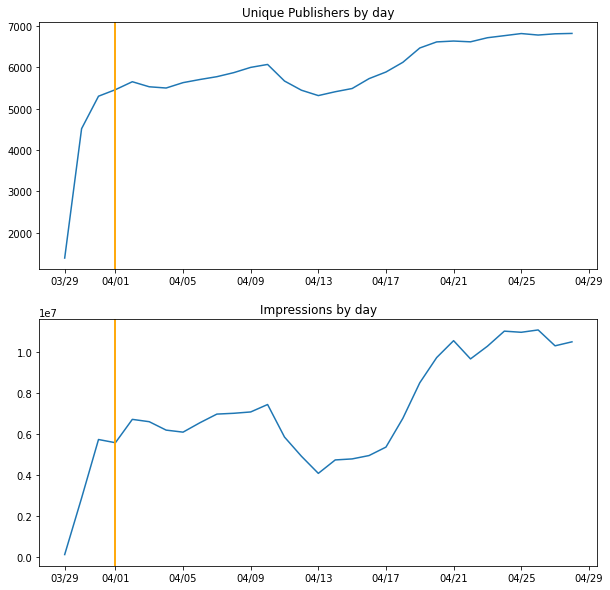

In [45]:
by_date = by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(by_date['hosting_app_id'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title('Unique Publishers by day')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(by_date['impressions'])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title('Impressions by day')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

                 hosting_app_id  impressions
impression type                             
banner                    12585    190666672
video                      6337     17360592
rewarded video             4730     10463328


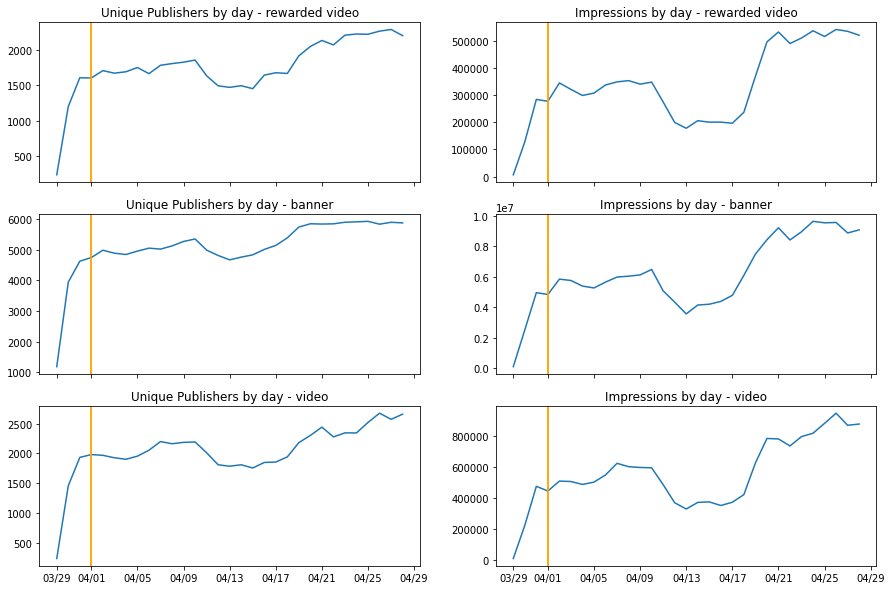

In [46]:
print(by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum}).sort_values('hosting_app_id', ascending = False))

by_date_type = by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(3,2,figsize = (15,10), sharex = True)

for n in range(3):
    type_filter = by_app_type_dt['impression type'].unique()[n]
    filtered_type = by_date_type.loc[:,by_date_type.columns.get_level_values(1) == type_filter]
    ax[n,0].plot(filtered_type['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique Publishers by day - {type_filter}')
    ax[n,1].plot(filtered_type['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions by day - {type_filter}')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [21]:
prev_apps = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.hosting_app_id
    , count(*)*16 as prev_impressions
from stats.attributes attr 
where 
    attr.date >= '{start_dt}' - 60 
    and attr.date <= '{start_dt}' - 1
    and left(attr.id,1) = '0'
    and attr.exchange_id = 41
group by 1,2
""").to_dataframe()
prev_apps

buyer  hosting_app_id  prev_impressions
0     RON         1047583                32
1      DT         1026518               208
2     RON         1123645                80
3     RON         1230828                16
4     RON         1191520                48
..    ...             ...               ...
990    DT          798024                16
991    DT         1124194                16
992    DT          630081                16
993    DT         1237968                16
994   RON      1462762106                16

[995 rows x 3 columns]

In [24]:
prev_apps_dt = prev_apps[prev_apps.buyer == 'DT']
new_apps_dt = by_app_type_dt.set_index(['buyer','hosting_app_id']).join(prev_apps_dt.set_index(['buyer','hosting_app_id']), how = 'left').reset_index()
new_apps_dt = new_apps_dt[(new_apps_dt.prev_impressions == 0) | (new_apps_dt.prev_impressions.isna())]
new_apps_dt


buyer  hosting_app_id       date  with_change  ad_size  imp_type  \
0         DT           42371 2021-03-29            0   320x50         1   
1         DT           42371 2021-03-30            0  480x320         1   
2         DT           42371 2021-03-30            0   320x50         1   
3         DT           42371 2021-03-31            0  480x320         1   
4         DT           42371 2021-03-31            0  320x480         1   
...      ...             ...        ...          ...      ...       ...   
350690    DT      1556510667 2021-04-22            1   320x50         1   
350691    DT      1556510667 2021-04-23            1   320x50         1   
350692    DT      1556510667 2021-04-24            1   320x50         1   
350693    DT      1556510667 2021-04-25            1   320x50         1   
350694    DT      1556510667 2021-04-28            1   320x50         1   

        impressions  clicks  installs  spend impression type  imp_type_id  \
0                16       0         0    0.0          banner            1   
1                16       0         0    0.0          banner            1   
2               736      16        16   16.0          banner            1   
3                16       0         0    0.0          banner            1   
4                64      16         0    0.0          banner            1   
...             ...     ...       ...    ...             ...          ...   
350690           16       0         0    NaN          banner            1   
350691           16       0         0    NaN          banner            1   
350692           64       0         0    NaN          banner            1   
350693           32       0         0    NaN          banner            1   
350694           32       0         0    NaN          banner            1   

        prev_impressions  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
350690               NaN  
350691               NaN  
350692               NaN  
350693               NaN  
350694               NaN  

[295262 rows x 13 columns]

Text(0.5, 1.0, 'Impressions from New Publishers by day')

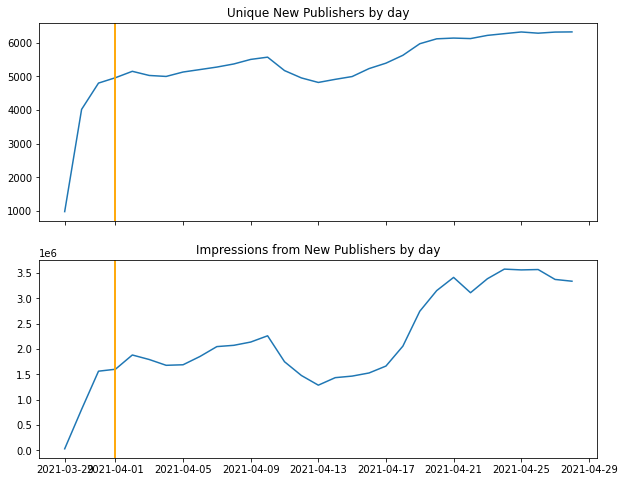

In [25]:
new_apps_byday = new_apps_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(2,1,figsize = (10,8), sharex = True)

ax[0].plot(new_apps_byday['hosting_app_id'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title(f'Unique New Publishers by day')
ax[1].plot(new_apps_byday['impressions'])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title(f'Impressions from New Publishers by day')

impression type
banner            54245264
video              7075568
rewarded video     5963376
Name: impressions, dtype: int64


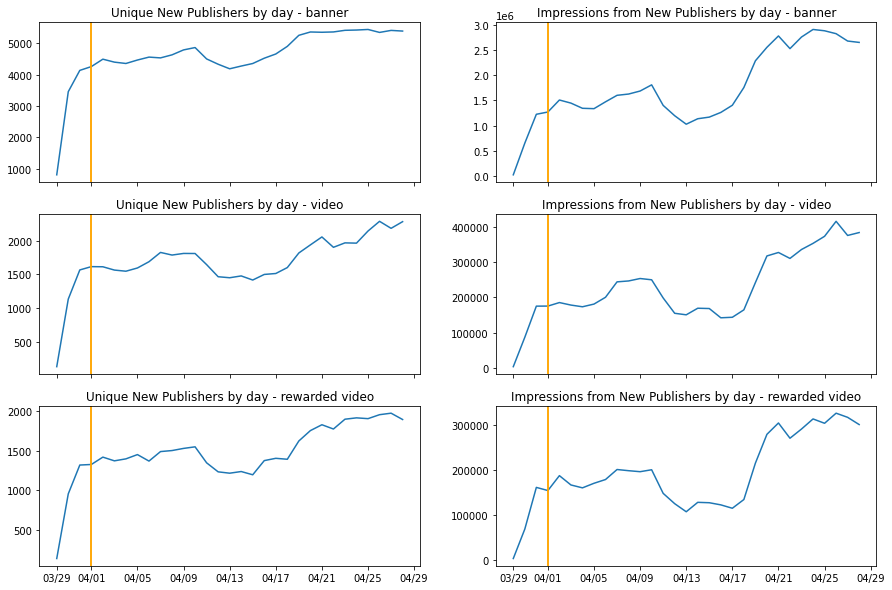

In [47]:
print(new_apps_dt.groupby('impression type')['impressions'].sum().sort_values(ascending = False))

new_apps_byday_bytype = new_apps_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(3,2,figsize = (15,10), sharex = True)

for n in range(3):
    type_filter = new_apps_dt['impression type'].unique()[n]
    filtered_type = new_apps_byday_bytype.loc[:,new_apps_byday_bytype.columns.get_level_values(1) == type_filter]
    ax[n,0].plot(filtered_type['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique New Publishers by day - {type_filter}')
    ax[n,1].plot(filtered_type['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions from New Publishers by day - {type_filter}')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

ad_size
320x50     42027952
320x480     7424720
480x320     3456912
300x250      884448
728x90       451232
Name: impressions, dtype: int64


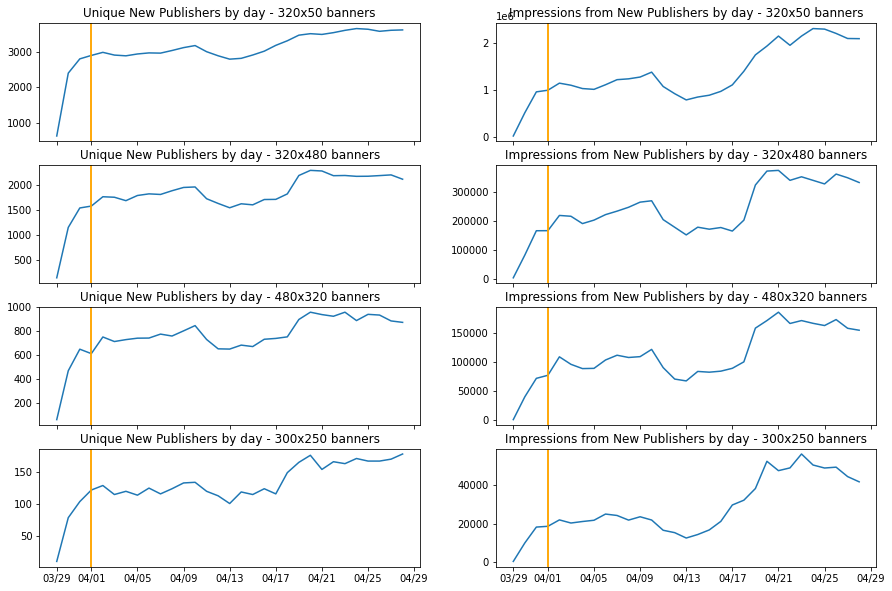

In [27]:
print(new_apps_dt[new_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False))
top_banner_sizes = new_apps_dt[new_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False).index.to_list()

new_apps_byday_bysize = new_apps_dt[new_apps_dt['impression type'] == 'banner'].pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'ad_size', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(4,2,figsize = (15,10), sharex = True)

for n in range(4):
    size_filter = top_banner_sizes[n]
    filtered_size = new_apps_byday_bysize.loc[:,new_apps_byday_bysize.columns.get_level_values(1) == size_filter]
    ax[n,0].plot(filtered_size['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique New Publishers by day - {size_filter} banners')
    ax[n,1].plot(filtered_size['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions from New Publishers by day - {size_filter} banners')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [28]:
existing_apps_dt = by_app_type_dt.set_index(['buyer','hosting_app_id']).join(prev_apps_dt.set_index(['buyer','hosting_app_id']), how = 'inner').reset_index()
top_banner_sizes = existing_apps_dt[existing_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False).index.to_list()

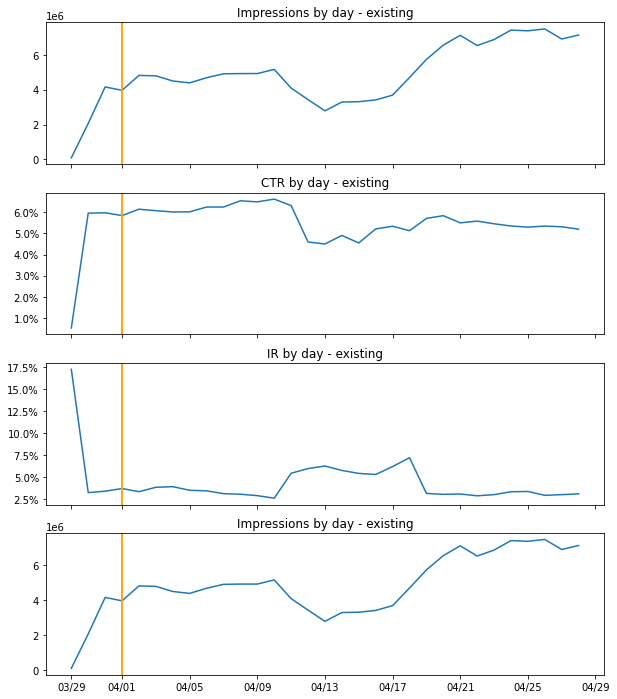

In [48]:
existing_apps_byday_dt = existing_apps_dt.pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', aggfunc = sum)

calc_metrics(existing_apps_byday_dt)
fig, ax = plt.subplots(4,1,figsize = (10,12), sharex = True)
ax[0].plot(existing_apps_byday_dt['impressions'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title(f'Impressions by day - existing')
ax[1].plot(existing_apps_byday_dt['ctr']*100)
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title(f'CTR by day - existing')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[2].plot(existing_apps_byday_dt['ir']*100)
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2].set_title(f'IR by day - existing')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[3].plot(existing_apps_byday_dt['impressions'])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[3].set_title(f'Impressions by day - existing')
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

<ipython-input-49-b5abace0d999>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
<ipython-input-49-b5abace0d999>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ir'] = sub_df['installs']/sub_df['clicks']
<ipython-input-49-b5abace0d999>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

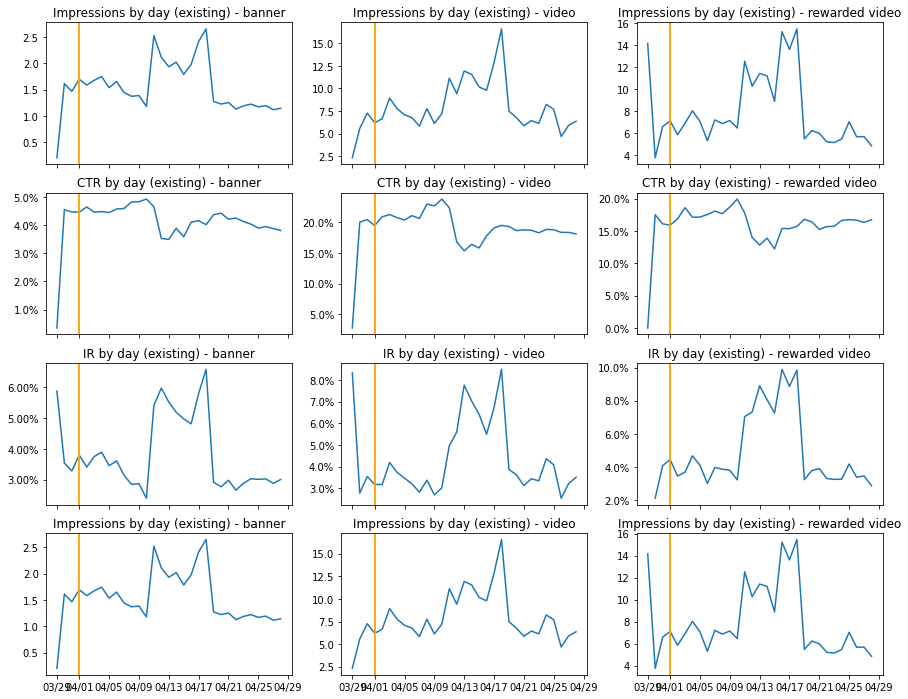

In [49]:
existing_apps_byday_bytype = existing_apps_dt.pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', columns = 'impression type', aggfunc = sum)
fig, ax = plt.subplots(4,3,figsize = (15,12), sharex = True)

for n in [1,0,2]:
    type_filter = existing_apps_dt['impression type'].unique()[n]
    sub_df = existing_apps_byday_bytype.loc[:,existing_apps_byday_bytype.columns.get_level_values(1) == type_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = sub_df['installs']/sub_df['clicks']
    sub_df['impressions'] = 1000*sub_df['installs']/sub_df['impressions']
    ax[0,n].plot(sub_df['impressions'])
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'Impressions by day (existing) - {type_filter}')
    ax[1,n].plot(sub_df['ctr']*100)
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[1,n].set_title(f'CTR by day (existing) - {type_filter}')
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2,n].plot(sub_df['ir']*100)
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].set_title(f'IR by day (existing) - {type_filter}')
    ax[2,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[3,n].plot(sub_df['impressions'])
    ax[3,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[3,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[3,n].set_title(f'Impressions by day (existing) - {type_filter}')
    ax[3,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


<ipython-input-31-bac95cd9a38e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
<ipython-input-31-bac95cd9a38e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ir'] = sub_df['installs']/sub_df['clicks']
<ipython-input-31-bac95cd9a38e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

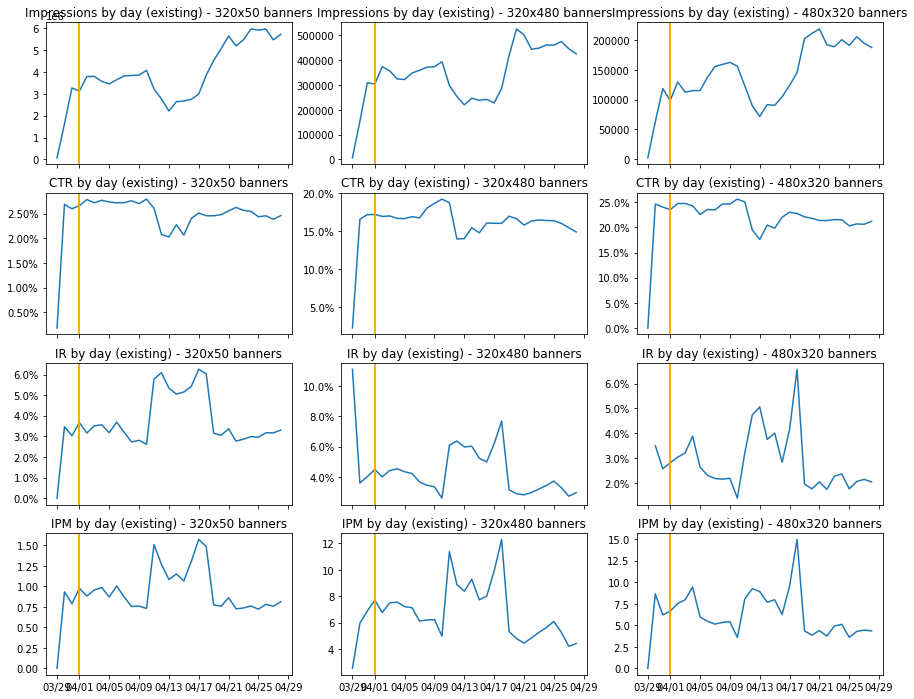

In [31]:
existing_apps_byday_bysize_banners_dt = existing_apps_dt[existing_apps_dt['impression type'] == 'banner'].pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', columns = 'ad_size', aggfunc = sum)
fig, ax = plt.subplots(4,3,figsize = (15,12), sharex = True)

for n in range(3):
    size_filter = top_banner_sizes[n]
    sub_df = existing_apps_byday_bysize_banners_dt.loc[:,existing_apps_byday_bysize_banners_dt.columns.get_level_values(1) == size_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = sub_df['installs']/sub_df['clicks']
    sub_df['impressions'] = 1000*sub_df['installs']/sub_df['impressions']
    ax[0,n].plot(sub_df['impressions'])
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'Impressions by day (existing) - {size_filter} banners')
    ax[1,n].plot(sub_df['ctr']*100)
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[1,n].set_title(f'CTR by day (existing) - {size_filter} banners')
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2,n].plot(sub_df['ir']*100)
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].set_title(f'IR by day (existing) - {size_filter} banners')
    ax[2,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[3,n].plot(sub_df['impressions'])
    ax[3,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[3,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[3,n].set_title(f'Impressions by day (existing) - {size_filter} banners')
    ax[3,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


In [32]:
bidding_df = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , attr.ad_size
    , attr.imp_type
    , sum(case when cleared > 0 then bid_price else 0 end)*16/1000 as total_bid
    , sum(case when cleared > 0 then settlement_price else 0 end)*16/1000 as total_cost
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 41
group by 1,2,3,4,5,6
""").to_dataframe()
bidding_df = bidding_df.set_index('imp_type').join(imp_type.set_index('imp_type_id'))
bidding_df

buyer        date  with_change     bidder   ad_size    total_bid  \
1     DT  2021-04-09            1  AutoPilot    728x90     1.293730   
1     DT  2021-03-29            0  AutoPilot    728x90     0.074478   
1     DT  2021-04-04            1  AutoPilot    728x90     2.071375   
1     DT  2021-04-15            1         ML    320x50  2929.743007   
1     DT  2021-04-18            1  AutoPilot   480x320  1070.306357   
..   ...         ...          ...        ...       ...          ...   
16    DT  2021-04-27            1  AutoPilot  1024x768   872.827113   
16    DT  2021-04-15            1         ML  1024x768   671.869609   
16    DT  2021-04-27            1         ML  768x1024  2456.926820   
16    DT  2021-03-31            0  AutoPilot  1024x768   579.338662   
16   RON  2021-04-23            1         ML  768x1024    54.713877   

     total_cost  impressions  clicks  installs   spend impression type  
1      1.291904          944      48         0     0.0          banner  
1      0.074464           48       0         0     0.0          banner  
1      2.070816         1760      16         0     0.0          banner  
1   2933.204448      2163328   42272      1664  4214.4          banner  
1   1069.374576        87792   19024      1744  2120.0          banner  
..          ...          ...     ...       ...     ...             ...  
16   871.994416        49408    8896       384   708.8  rewarded video  
16   672.219040        34944    4320       416   886.4  rewarded video  
16  2454.641248       231600   35616      1440  2471.2  rewarded video  
16   579.633008        43680    7456       384   695.2  rewarded video  
16    54.701296         9440     992        16     4.8  rewarded video  

[1116 rows x 12 columns]

In [33]:
bidding_df_dt = bidding_df[bidding_df.buyer == 'DT']
bidding_df_dt.groupby('bidder').sum()

with_change      total_bid     total_cost  impressions   clicks  \
bidder                                                                       
AutoPilot          243  356960.186586  356962.040750     72194144  5271808   
ML                 243  501393.096764  501414.646397    146296448  8294560   

           installs      spend  
bidder                          
AutoPilot    259296  403300.48  
ML           309664  565432.00

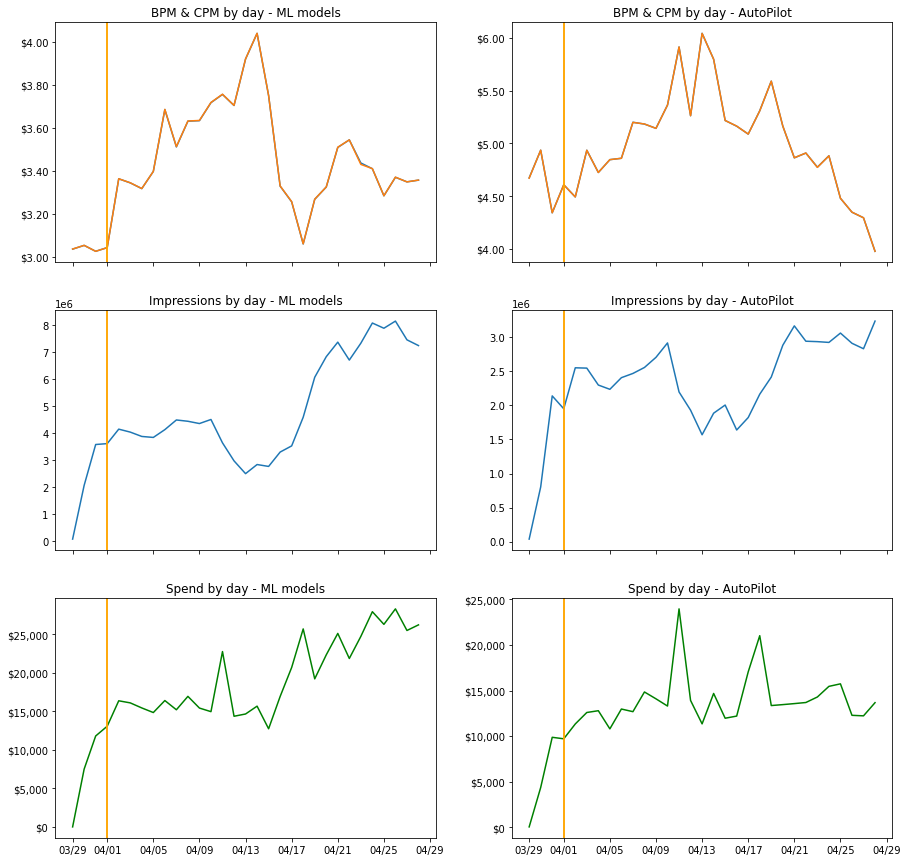

In [50]:
by_day_total_ml_dt = bidding_df_dt[bidding_df_dt.bidder == 'ML'].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = ['date'], aggfunc = np.sum)
by_day_total_ap_dt = bidding_df_dt[bidding_df_dt.bidder == 'AutoPilot'].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = ['date'], aggfunc = np.sum)
by_day_total_ml_dt['bpm'] = 1000*by_day_total_ml_dt['total_bid']/by_day_total_ml_dt['impressions']
by_day_total_ml_dt['cpm'] = 1000*by_day_total_ml_dt['total_cost']/by_day_total_ml_dt['impressions']
by_day_total_ap_dt['bpm'] = 1000*by_day_total_ap_dt['total_bid']/by_day_total_ap_dt['impressions']
by_day_total_ap_dt['cpm'] = 1000*by_day_total_ap_dt['total_cost']/by_day_total_ap_dt['impressions']

fig, ax = plt.subplots(3,2, figsize = (15,15), sharex = True)
ax[0,0].plot(by_day_total_ml_dt[['bpm','cpm']])
ax[0,0].yaxis.set_major_formatter('${x:1.2f}')
ax[0,0].set_title('BPM & CPM by day - ML models')
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,0].plot(by_day_total_ml_dt['impressions'])
ax[1,0].set_title('Impressions by day - ML models')
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,0].plot(by_day_total_ml_dt['spend'], color = 'green')
ax[2,0].yaxis.set_major_formatter('${x:,.0f}')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,0].set_title('Spend by day - ML models')
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0,1].plot(by_day_total_ap_dt[['bpm','cpm']])
ax[0,1].yaxis.set_major_formatter('${x:1.2f}')
ax[0,1].set_title('BPM & CPM by day - AutoPilot')
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,1].plot(by_day_total_ap_dt['impressions'])
ax[1,1].set_title('Impressions by day - AutoPilot')
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,1].plot(by_day_total_ap_dt['spend'], color = 'green')
ax[2,1].yaxis.set_major_formatter('${x:,.0f}')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,1].set_title('Spend by day - AutoPilot')
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

<ipython-input-35-ce7ce9bc8363>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
<ipython-input-35-ce7ce9bc8363>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']


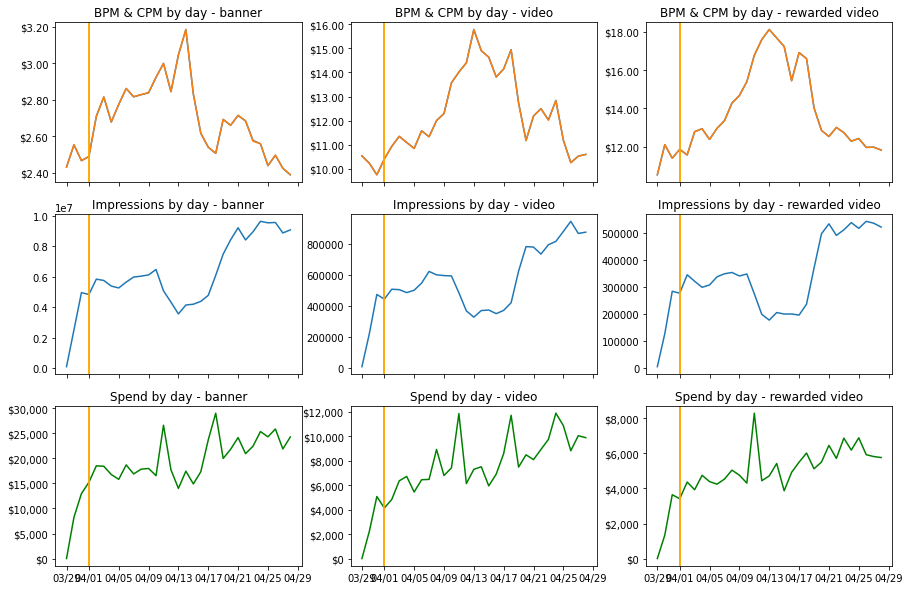

In [35]:
bidding_by_day_by_type_dt = bidding_df_dt.pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
fig, ax = plt.subplots(3,3, figsize = (15,10), sharex = True)
for n in range(3):
    type_filter = bidding_df_dt['impression type'].unique()[n]

    sub_df = bidding_by_day_by_type_dt.loc[:,bidding_by_day_by_type_dt.columns.get_level_values(1) == type_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
    sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']
    
    ax[0,n].plot(sub_df[['bpm','cpm']])
    ax[0,n].yaxis.set_major_formatter('${x:1.2f}')
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'BPM & CPM by day - {type_filter}')
    ax[1,n].plot(sub_df['impressions'])
    ax[1,n].set_title(f'Impressions by day - {type_filter}')
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].plot(sub_df['spend'], color = 'green')
    ax[2,n].yaxis.set_major_formatter('${x:,.0f}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].set_title(f'Spend by day - {type_filter}')
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

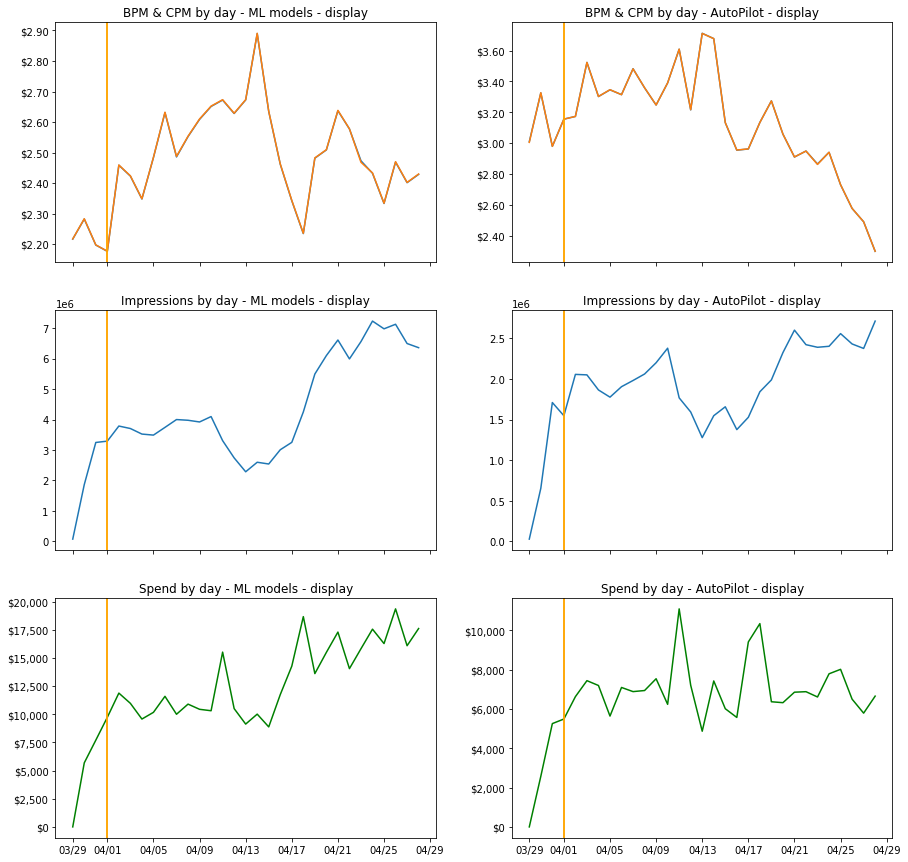

In [51]:
bidding_by_day_banner_ml_dt = bidding_df_dt[(bidding_df_dt.bidder == 'ML') & (bidding_df_dt['impression type'] == 'banner')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
bidding_by_day_banner_ap_dt = bidding_df_dt[(bidding_df_dt.bidder == 'AutoPilot') & (bidding_df_dt['impression type'] == 'banner')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
bidding_by_day_banner_ml_dt['bpm'] = 1000*bidding_by_day_banner_ml_dt['total_bid']/bidding_by_day_banner_ml_dt['impressions']
bidding_by_day_banner_ml_dt['cpm'] = 1000*bidding_by_day_banner_ml_dt['total_cost']/bidding_by_day_banner_ml_dt['impressions']
bidding_by_day_banner_ap_dt['bpm'] = 1000*bidding_by_day_banner_ap_dt['total_bid']/bidding_by_day_banner_ap_dt['impressions']
bidding_by_day_banner_ap_dt['cpm'] = 1000*bidding_by_day_banner_ap_dt['total_cost']/bidding_by_day_banner_ap_dt['impressions']
fig, ax = plt.subplots(3,2, figsize = (15,15), sharex = True)
ax[0,0].plot(bidding_by_day_banner_ml_dt[['bpm','cpm']])
ax[0,0].yaxis.set_major_formatter('${x:1.2f}')
ax[0,0].set_title('BPM & CPM by day - ML models - display')
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,0].plot(bidding_by_day_banner_ml_dt['impressions'])
ax[1,0].set_title('Impressions by day - ML models - display')
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,0].plot(bidding_by_day_banner_ml_dt['spend'], color = 'green')
ax[2,0].yaxis.set_major_formatter('${x:,.0f}')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,0].set_title('Spend by day - ML models - display')
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0,1].plot(bidding_by_day_banner_ap_dt[['bpm','cpm']])
ax[0,1].yaxis.set_major_formatter('${x:1.2f}')
ax[0,1].set_title('BPM & CPM by day - AutoPilot - display')
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,1].plot(bidding_by_day_banner_ap_dt['impressions'])
ax[1,1].set_title('Impressions by day - AutoPilot - display')
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,1].plot(bidding_by_day_banner_ap_dt['spend'], color = 'green')
ax[2,1].yaxis.set_major_formatter('${x:,.0f}')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,1].set_title('Spend by day - AutoPilot - display')
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

<ipython-input-52-2cf24db992e9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].groupby('ad_size')['spend','impressions'].sum().sort_values('impressions',ascending = False))
<ipython-input-52-2cf24db992e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
<ipython-input-52-2cf24db992e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

            spend  impressions
ad_size                       
320x50   202262.4    112605264
320x480  120550.4     11725616
480x320   56055.2      5122752
300x250     998.4      1108512
728x90      992.0      1085792


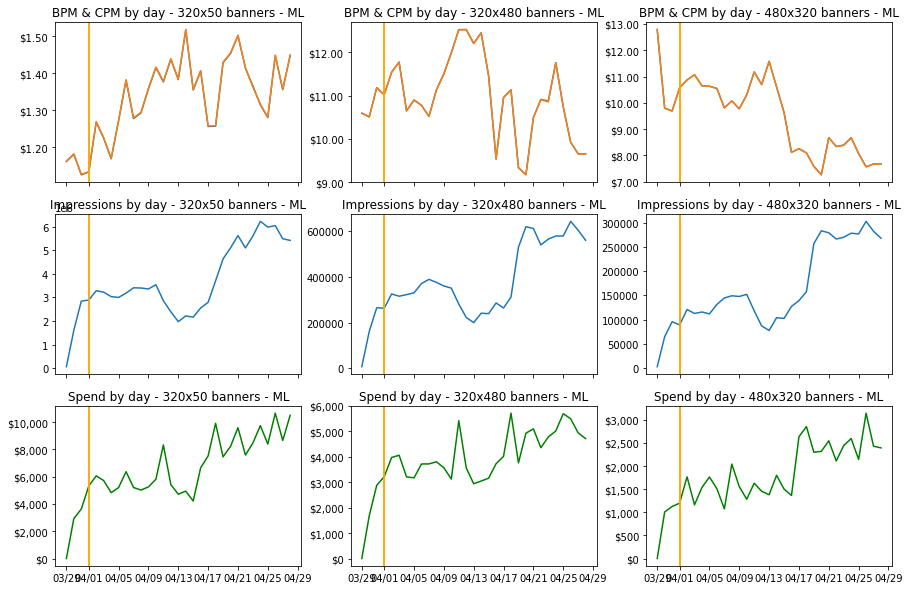

In [52]:
print(bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].groupby('ad_size')['spend','impressions'].sum().sort_values('impressions',ascending = False))

bidding_by_day_by_size_dt = bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'ad_size', aggfunc = np.sum)
fig, ax = plt.subplots(3,3, figsize = (15,10), sharex = True)
for n in range(3):
    size_filter = top_banner_sizes[n]

    sub_df = bidding_by_day_by_size_dt.loc[:,bidding_by_day_by_size_dt.columns.get_level_values(1) == size_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
    sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']
    
    ax[0,n].plot(sub_df[['bpm','cpm']])
    ax[0,n].yaxis.set_major_formatter('${x:1.2f}')
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'BPM & CPM by day - {size_filter} banners - ML')
    ax[1,n].plot(sub_df['impressions'])
    ax[1,n].set_title(f'Impressions by day - {size_filter} banners - ML')
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].plot(sub_df['spend'], color = 'green')
    ax[2,n].yaxis.set_major_formatter('${x:,.0f}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].set_title(f'Spend by day - {size_filter} banners - ML')
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

### Looking at new users

In [ ]:
by_user = bigquery_client.query(f"""
select
    attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , attr.ad_size
    , attr.hosting_app_id
    , pubs.bundle 
    , attr.sponsored_app_id
    , packages.name as package_name
    , sum(case when cleared > 0 then bid_price else 0 end)*16/1000 as total_bid
    , sum(case when cleared > 0 then settlement_price else 0 end)*16/1000 as total_cost
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
left join metadata.apps packages
    on attr.sponsored_app_id = packages.app_id
left join metadata.apps pubs
    on attr.hosting_app_id = pubs.app_id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and attr.ssb_buyer_id = 3549
    and left(attr.id,1) = '0'
    and attr.exchange_id = 41
    and attr.imp_type = 1
group by 1,2,3,4,5,6,7,8
""").to_dataframe()

drilldown_dt

In [ ]:
top_packages_pivot = drilldown_dt.groupby(['sponsored_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)
top_packages = top_packages_pivot.index.to_list()[0:4] + top_packages_pivot.index.to_list()[5:20]
top_packages_pivot

Text(0.5, 1.0, 'impressions by day')

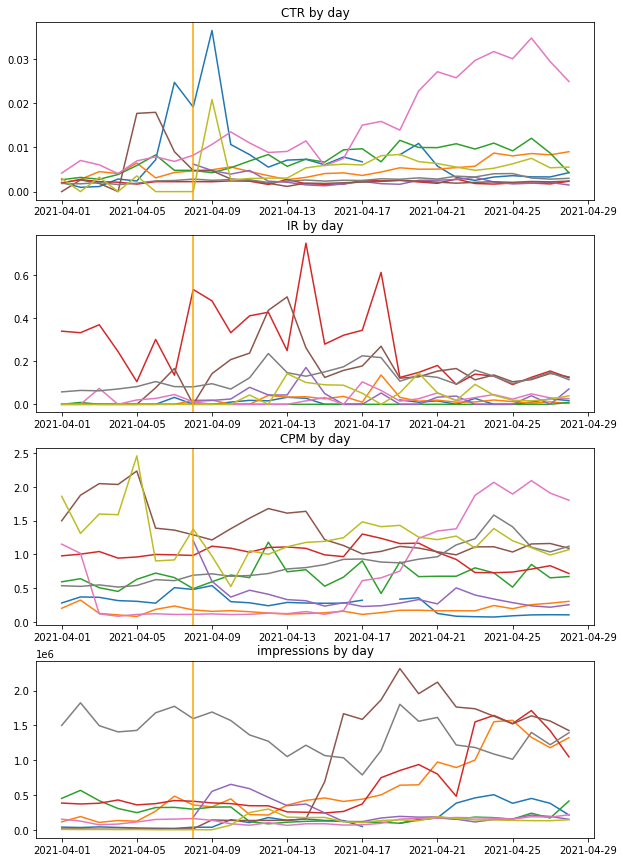

In [848]:
filtered_drilldown = drilldown_dt.loc[(drilldown_dt.sponsored_app_id.isin(top_packages))].pivot_table(values = ['impressions','clicks','installs','total_cost','spend'], index = ['sponsored_app_id','date'], aggfunc = np.sum)
filtered_drilldown['cpm'] = 1000*filtered_drilldown['total_cost']/filtered_drilldown['impressions']
calc_metrics(filtered_drilldown)
top_pub_metrics = filtered_drilldown.reset_index().pivot_table(values = ['ctr','ir','cpm','impressions'], index = 'date', columns = 'sponsored_app_id', aggfunc = np.sum)

fig, ax = plt.subplots(4,1, figsize = (10,15))
ax[0].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ctr']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR by day')
ax[1].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ir']])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR by day')
ax[2].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'cpm']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('CPM by day')
ax[3].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'impressions']])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].set_title('impressions by day')

In [832]:
top_pubs_pivot = drilldown_dt.groupby(['hosting_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)
top_pubs = top_pubs_pivot.index.to_list()[0:10]
top_pubs_pivot

<ipython-input-832-6426f6b5bab5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_pubs_pivot = drilldown_dt.groupby(['hosting_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)


impressions    spend
hosting_app_id                      
309226             12491616  1404.00
1068506            12456048  6006.40
148078             10609072  4542.88
95814               4207696  1621.60
947773              4074416   887.20
96379               3895824  2221.60
68842               3833408   292.00
1006661             2967440  1364.00
1049297             2544752  9814.40
99827               2464880   542.40

Text(0.5, 1.0, 'impressions by day')

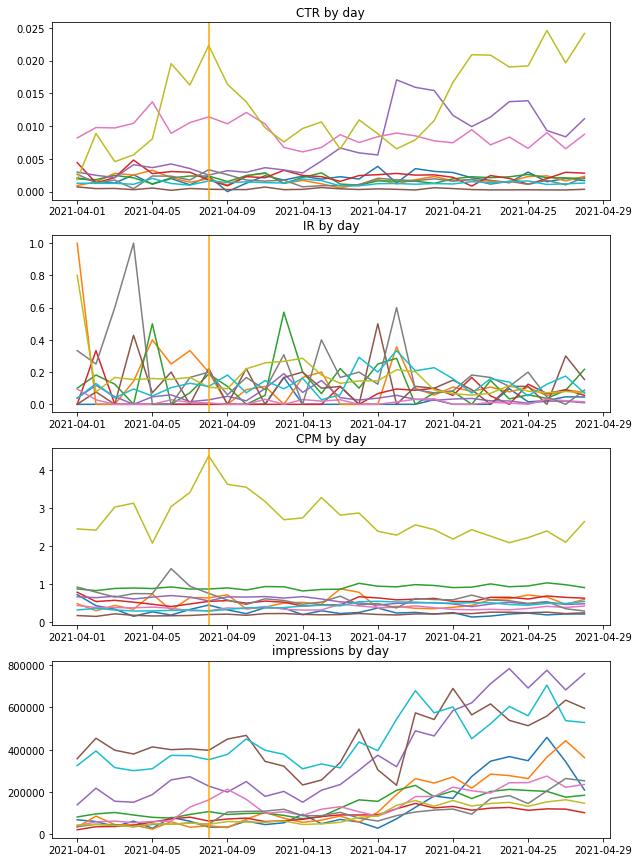

In [837]:
filtered_drilldown = drilldown_dt.loc[(drilldown_dt.hosting_app_id.isin(top_pubs))].pivot_table(values = ['impressions','clicks','installs','total_cost','spend'], index = ['hosting_app_id','date'], aggfunc = np.sum)
filtered_drilldown['cpm'] = 1000*filtered_drilldown['total_cost']/filtered_drilldown['impressions']
calc_metrics(filtered_drilldown)
top_pub_metrics = filtered_drilldown.reset_index().pivot_table(values = ['ctr','ir','cpm','impressions'], index = 'date', columns = 'hosting_app_id', aggfunc = np.sum)

fig, ax = plt.subplots(4,1, figsize = (10,15))
ax[0].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ctr']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR by day')
ax[1].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ir']])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR by day')
ax[2].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'cpm']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('CPM by day')
ax[3].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'impressions']])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].set_title('impressions by day')